In [2]:
!pip install -q vit-keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score
)

from vit_keras import vit


2025-12-25 09:02:33.288867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766653353.476924      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766653353.532344      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
train_dir = '/kaggle/input/skin-mal-ben-bcc-balanced/ISIC_BALANCED/train'
val_dir   = '/kaggle/input/skin-mal-ben-bcc-balanced/ISIC_BALANCED/val'
test_dir  = '/kaggle/input/skin-mal-ben-bcc-balanced/ISIC_BALANCED/test'


In [5]:
IMG_SIZE = 224
BATCH_SIZE = 16   # ViT needs smaller batch size
NUM_CLASSES = 3


In [6]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_aug  = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)


In [8]:
train_gen = train_aug.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_aug.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_aug.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1852 images belonging to 3 classes.
Found 463 images belonging to 3 classes.
Found 1060 images belonging to 3 classes.


In [9]:
def build_vit_only():
    vit_base = vit.vit_b16(
        image_size=IMG_SIZE,
        pretrained=True,
        include_top=False,
        pretrained_top=False
    )

    # Freeze most layers (VERY IMPORTANT)
    for layer in vit_base.layers[:-24]:
        layer.trainable = False

    x = vit_base.output
    x = LayerNormalization()(x)
    x = Dense(256, activation='gelu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    return Model(vit_base.input, outputs)


In [10]:
vit_model = build_vit_only()

vit_model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc', multi_label=True)
    ]
)

vit_model.summary()


I0000 00:00:1766653418.866112      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766653418.866692      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


347502902/347502902 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:85: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Conv2D)              │ (None, 14, 14, 768)    │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 196, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_token (ClassToken)        │ (None, 197, 768)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_posembed_input      │ (None, 197, 768)       │       151,296 │
│ (AddPositionEmbs)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_encoderblock_0      │ [(None, 197, 768),     │     7,087,872 │
│ (TransformerBlock)              │ (None, 12, None,       │               │
│                                 │ None)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_encoderblock_1      │ [(None, 197, 768),     │     7,087,872 │
│ (TransformerBlock)              │ (None, 12, None,       │               │
│                                 │ None)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_encoderblock_2      │ [(None, 197, 768),     │     7,087,872 │
│ (TransformerBlock)              │ (None, 12, None,       │               │
│                                 │ None)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_encoderblock_3      │ [(None, 197, 768),     │     7,087,872 │
│ (TransformerBlock)              │ (None, 12, None,       │               │
│                                 │ None)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_encoderblock_4      │ [(None, 197, 768),     │     7,087,872 │
│ (TransformerBlock)              │ (None, 12, None,       │               │
│                                 │ None)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_encoderblock_5      │ [(None, 197, 768),     │     7,087,872 │
│ (TransformerBlock)              │ (None, 12, None,       │               │
│                                 │ None)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_encoderblock_6      │ [(None, 197, 768),     │     7,087,872 │
│ (TransformerBlock)              │ (None, 12, None,       │               │
│                                 │ None)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_encoderblock_7      │ [(None, 197, 768),     │     7,087,872 │
│ (TransformerBlock)              │ (None, 12, None,       │               │
│                                 │ None)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_encoderblock_8      │ [(None, 197, 768),     │     7,087,872 │
│ (TransformerBlock)              │ (None, 12, None,       │               │
│                                 │ None)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Transformer_encoderblock_9      │ [(None, 197, 768),     │     7,087,872 │
│ (TransformerBlock)              │ (None, 12, None,       │             

 Total params: 85,997,827 (328.06 MB)

 Trainable params: 85,997,827 (328.06 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
callbacks = [
    EarlyStopping(monitor='val_auc', patience=12, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', patience=5, factor=0.3)
]

history_vit = vit_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

vit_model.save("vit_only.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1766653459.698128     146 service.cc:148] XLA service 0x7dc5c8003200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766653459.699086     146 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766653459.699107     146 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766653464.530084     146 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1766653492.981512     146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


116/116 ━━━━━━━━━━━━━━━━━━━━ 180s 998ms/step - accuracy: 0.5950 - auc: 0.7754 - loss: 0.9991 - val_accuracy: 0.8467 - val_auc: 0.9526 - val_loss: 0.3953 - learning_rate: 1.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 88s 756ms/step - accuracy: 0.7984 - auc: 0.9263 - loss: 0.5076 - val_accuracy: 0.8467 - val_auc: 0.9625 - val_loss: 0.3731 - learning_rate: 1.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 88s 757ms/step - accuracy: 0.8451 - auc: 0.9604 - loss: 0.3632 - val_accuracy: 0.8315 - val_auc: 0.9640 - val_loss: 0.4114 - learning_rate: 1.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 88s 757ms/step - accuracy: 0.8784 - auc: 0.9706 - loss: 0.3146 - val_accuracy: 0.8445 - val_auc: 0.9615 - val_loss: 0.4080 - learning_rate: 1.0000e-04
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 89s 763ms/step - accuracy: 0.8804 - auc: 0.9755 - loss: 0.2887 - val_accuracy: 0.8834 - val_auc: 0.9745 - val_loss: 0.3033 - learning_rate: 1.0000e-04
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 88s 760ms/step 

In [17]:
import keras
keras.config.enable_unsafe_deserialization()


In [18]:
vit_model = tf.keras.models.load_model("vit_only.keras", compile=False)


In [19]:
# ===== REQUIRED IMPORTS =====
import numpy as np
import tensorflow as tf
import keras
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)
from tensorflow.keras.utils import to_categorical

# ===== ENABLE LAMBDA DESERIALIZATION =====
keras.config.enable_unsafe_deserialization()

# ===== LOAD MODEL =====
vit_model = tf.keras.models.load_model("vit_only.keras", compile=False)

# ===== PREDICT =====
test_gen.reset()
p_vit = vit_model.predict(test_gen, verbose=1)

# ===== LABELS =====
y_pred = np.argmax(p_vit, axis=1)
y_true = test_gen.classes
NUM_CLASSES = 3

# ===== METRICS =====
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec  = recall_score(y_true, y_pred, average='macro')
f1   = f1_score(y_true, y_pred, average='macro')
auc  = roc_auc_score(
    to_categorical(y_true, NUM_CLASSES),
    p_vit,
    multi_class='ovr'
)

print("Accuracy  :", acc)
print("Precision :", prec)
print("Recall    :", rec)
print("F1-score  :", f1)
print("AUC-ROC   :", auc)

print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=test_gen.class_indices.keys()
))


67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step
Accuracy  : 0.9
Precision : 0.894178607681158
Recall    : 0.8946296296296296
F1-score  : 0.8943875719848053
AUC-ROC   : 0.9818067897015266

Classification Report:

              precision    recall  f1-score   support

         BCC       0.96      0.96      0.96       400
      benign       0.89      0.88      0.88       360
   malignant       0.83      0.84      0.84       300

    accuracy                           0.90      1060
   macro avg       0.89      0.89      0.89      1060
weighted avg       0.90      0.90      0.90      1060



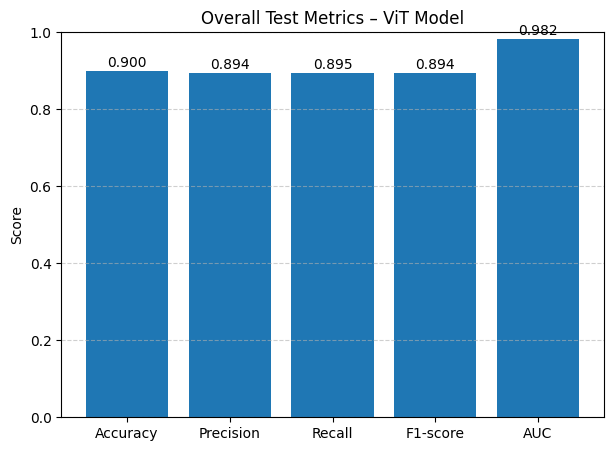

In [26]:
auc_score = roc_auc_score(to_categorical(y_true,3), p_vit, multi_class='ovr')
import matplotlib.pyplot as plt

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
metrics_values = [acc, prec, rec, f1, auc_score]

plt.figure(figsize=(7,5))
bars = plt.bar(metrics_names, metrics_values)
plt.ylim(0,1)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height:.3f}",
        ha='center',
        fontsize=10
    )

plt.title("Overall Test Metrics – ViT Model")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


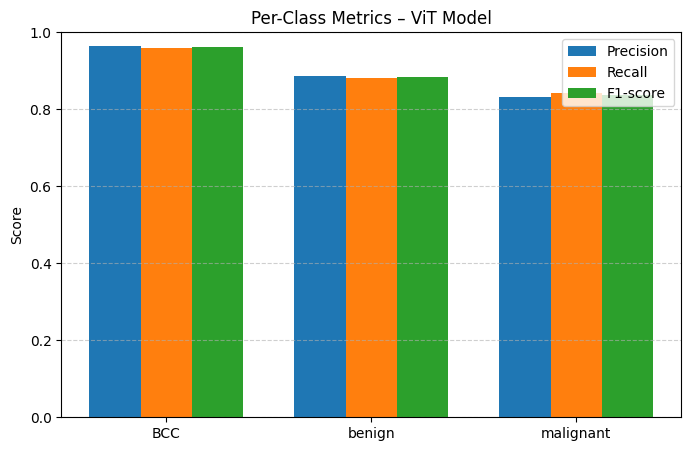

In [24]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

precision, recall, f1_class, _ = precision_recall_fscore_support(
    y_true, y_pred
)

class_names = list(test_gen.class_indices.keys())

x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_class, width, label='F1-score')

plt.xticks(x, class_names)
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Per-Class Metrics – ViT Model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


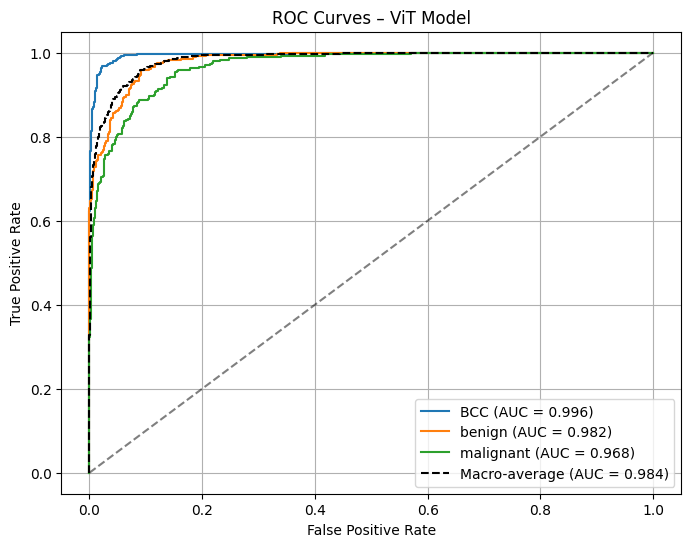

In [21]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import numpy as np

# Prepare labels
y_true_cat = to_categorical(y_true, num_classes=3)
class_names = list(test_gen.class_indices.keys())

plt.figure(figsize=(8,6))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_cat[:, i], p_vit[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.3f})")

# Macro-average ROC
fpr_macro, tpr_macro, _ = roc_curve(y_true_cat.ravel(), p_vit.ravel())
roc_auc_macro = auc(fpr_macro, tpr_macro)
plt.plot(fpr_macro, tpr_macro, linestyle="--", color="black",
         label=f"Macro-average (AUC = {roc_auc_macro:.3f})")

# Chance line
plt.plot([0,1], [0,1], 'k--', alpha=0.5)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – ViT Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


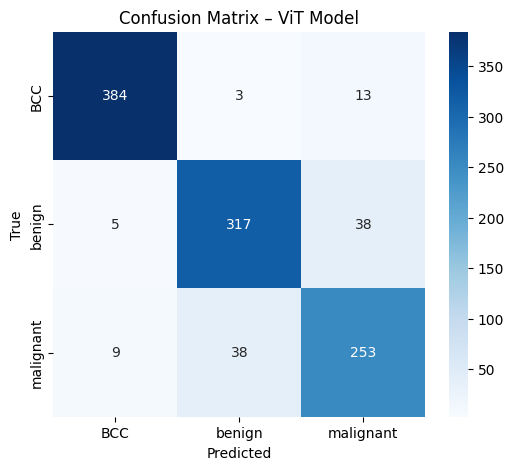

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=class_names,
    yticklabels=class_names,
    cmap='Blues'
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – ViT Model")
plt.show()
